Let's try with a CNN LSTM Neural Network

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = [50, 25]

# First Model: LSTM with only 1 layer

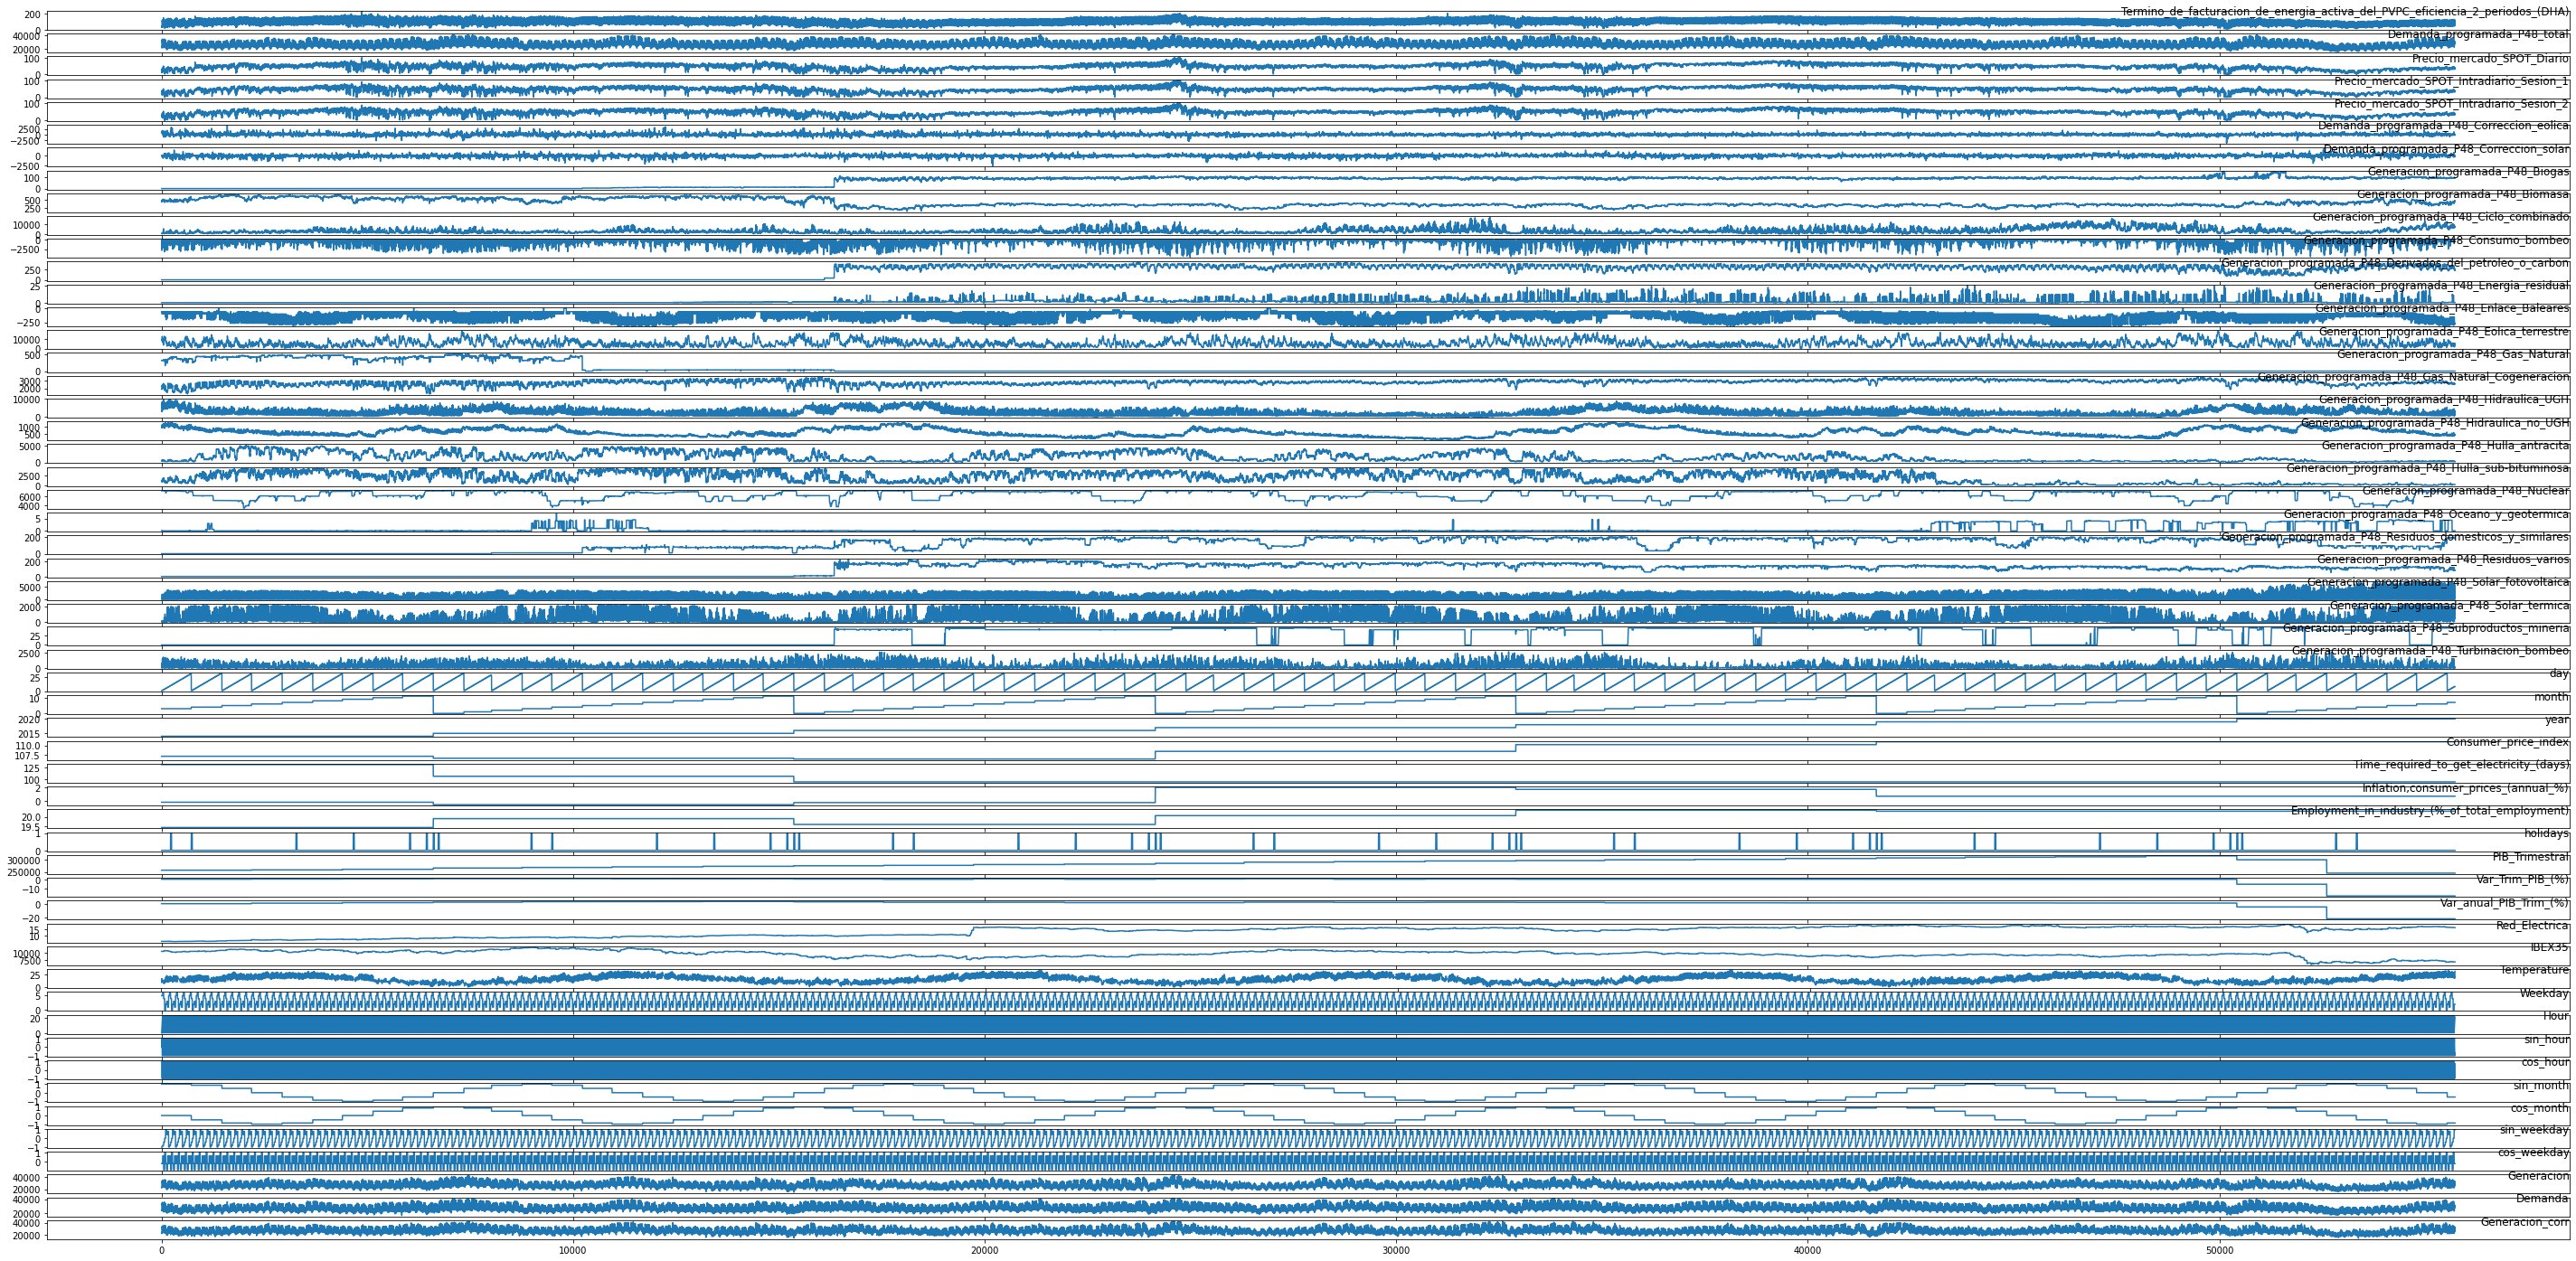

In [2]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

values = df.values
# specify columns to plot
groups = np.arange(len(df.columns.to_list()))
i = 1
# plot each column
plt.rcParams['figure.figsize'] = [50, 25]
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

model_columns = ['Demanda_programada_P48_total', 
                 'Precio_mercado_SPOT_Diario',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays', 'Temperature',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [3]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [4]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [5]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [6]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']+model_columns]

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)

# Then we split into X and y:
X = df3.loc[:,model_columns]
y = df3.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

# We separate into train and test:
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,]

# Pasamos a float todo:
X_train = X_train_aux.values.astype('float32')
y_train = y_train_aux.values.astype('float32')
X_test = X_test_aux.values.astype('float32')
y_test = y_test_aux.values.astype('float32')

In [7]:
# Comprobamos el porcentaje de divivsión entre train y test
y_test.shape[0]/(y_train.shape[0]+y_test.shape[0])

0.18488514437963563

In [8]:
# Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Epoch 1/150
10/10 - 8s - loss: 0.0669 - val_loss: 0.0570
Epoch 2/150
10/10 - 7s - loss: 0.0470 - val_loss: 0.0365
Epoch 3/150
10/10 - 8s - loss: 0.0329 - val_loss: 0.0232
Epoch 4/150
10/10 - 7s - loss: 0.0251 - val_loss: 0.0284
Epoch 5/150
10/10 - 8s - loss: 0.0229 - val_loss: 0.0236
Epoch 6/150
10/10 - 8s - loss: 0.0197 - val_loss: 0.0199
Epoch 7/150
10/10 - 7s - loss: 0.0174 - val_loss: 0.0211
Epoch 8/150
10/10 - 2s - loss: 0.0157 - val_loss: 0.0181
Epoch 9/150
10/10 - 7s - loss: 0.0143 - val_loss: 0.0179
Epoch 10/150
10/10 - 8s - loss: 0.0132 - val_loss: 0.0167
Epoch 11/150
10/10 - 8s - loss: 0.0123 - val_loss: 0.0162
Epoch 12/150
10/10 - 8s - loss: 0.0115 - val_loss: 0.0156
Epoch 13/150
10/10 - 6s - loss: 0.0110 - val_loss: 0.0155
Epoch 14/150
10/10 - 7s - loss: 0.0105 - val_loss: 0.0152
Epoch 15/150
10/10 - 9s - loss: 0.0102 - val_loss: 0.0153
Epoch 16/150
10/10 - 6s - loss: 0.0099 - val_loss: 0.0153
Epoch 17/150
10/10 - 5s - loss: 0.0097 - val_loss: 0.0154
Epoch 18/150
10/10 - 8s

Epoch 142/150
10/10 - 0s - loss: 0.0062 - val_loss: 0.0110
Epoch 143/150
10/10 - 0s - loss: 0.0062 - val_loss: 0.0102
Epoch 144/150
10/10 - 0s - loss: 0.0062 - val_loss: 0.0110
Epoch 145/150
10/10 - 0s - loss: 0.0061 - val_loss: 0.0105
Epoch 146/150
10/10 - 0s - loss: 0.0061 - val_loss: 0.0108
Epoch 147/150
10/10 - 0s - loss: 0.0061 - val_loss: 0.0106
Epoch 148/150
10/10 - 0s - loss: 0.0061 - val_loss: 0.0107
Epoch 149/150
10/10 - 0s - loss: 0.0061 - val_loss: 0.0106
Epoch 150/150
10/10 - 0s - loss: 0.0060 - val_loss: 0.0106


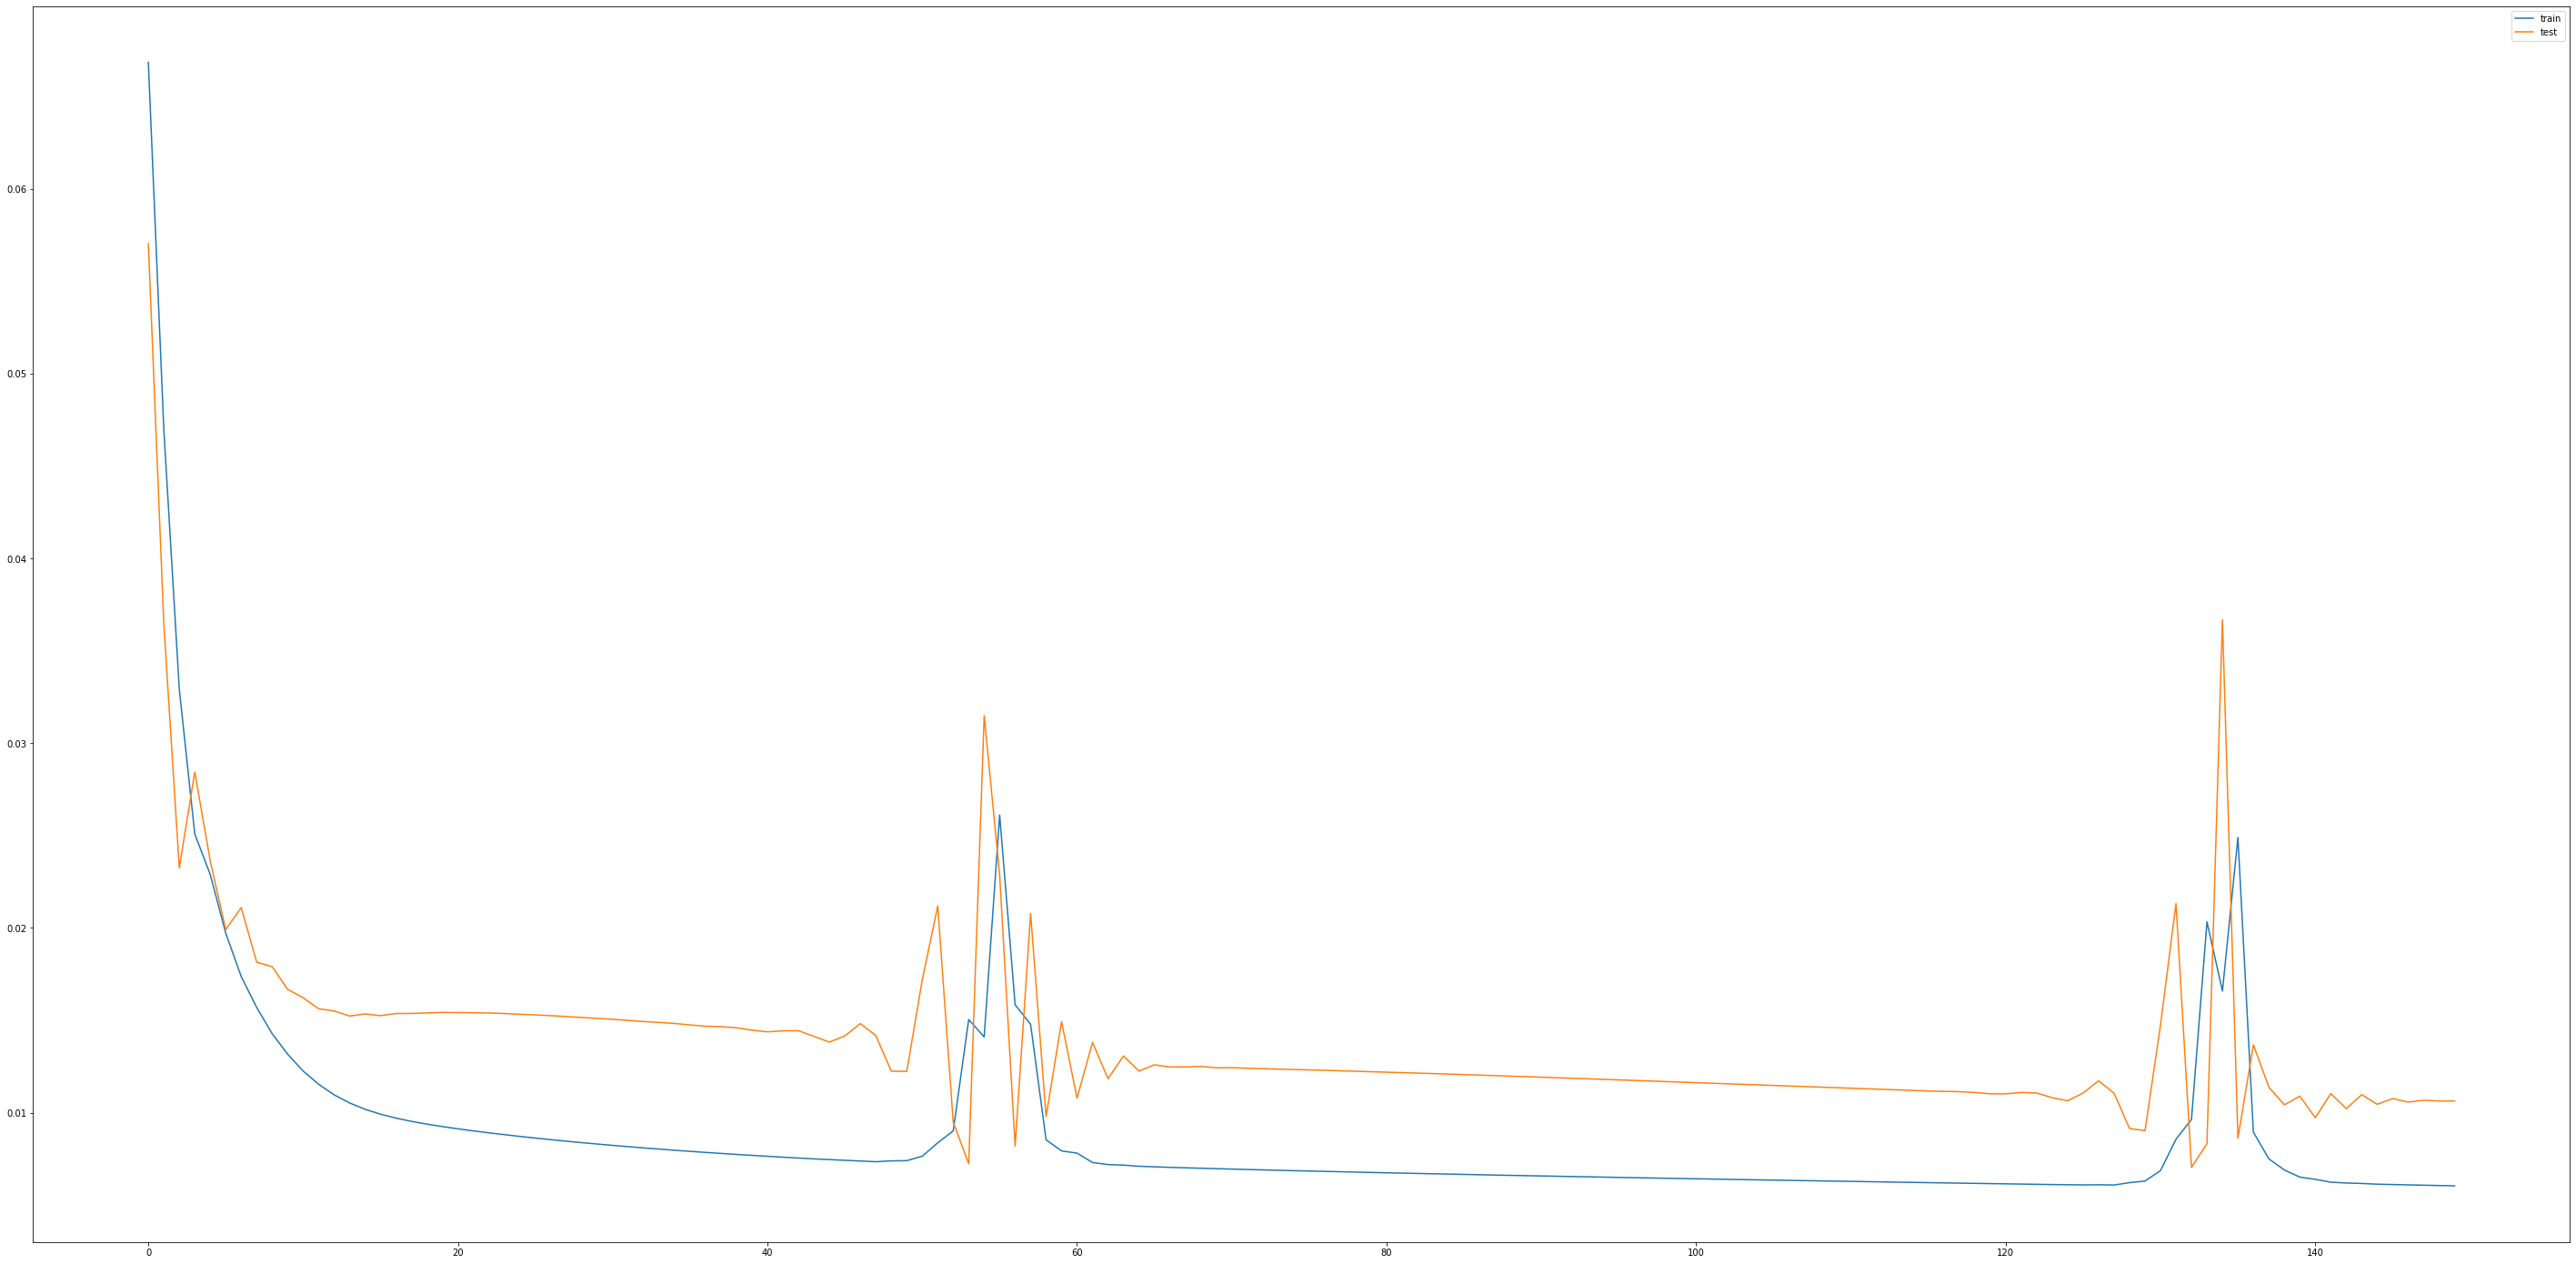

CPU times: user 1min 36s, sys: 5.73 s, total: 1min 42s
Wall time: 6min 29s


In [9]:
%%time
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=150, batch_size=5000, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 21.798 and Test R2: 0.634


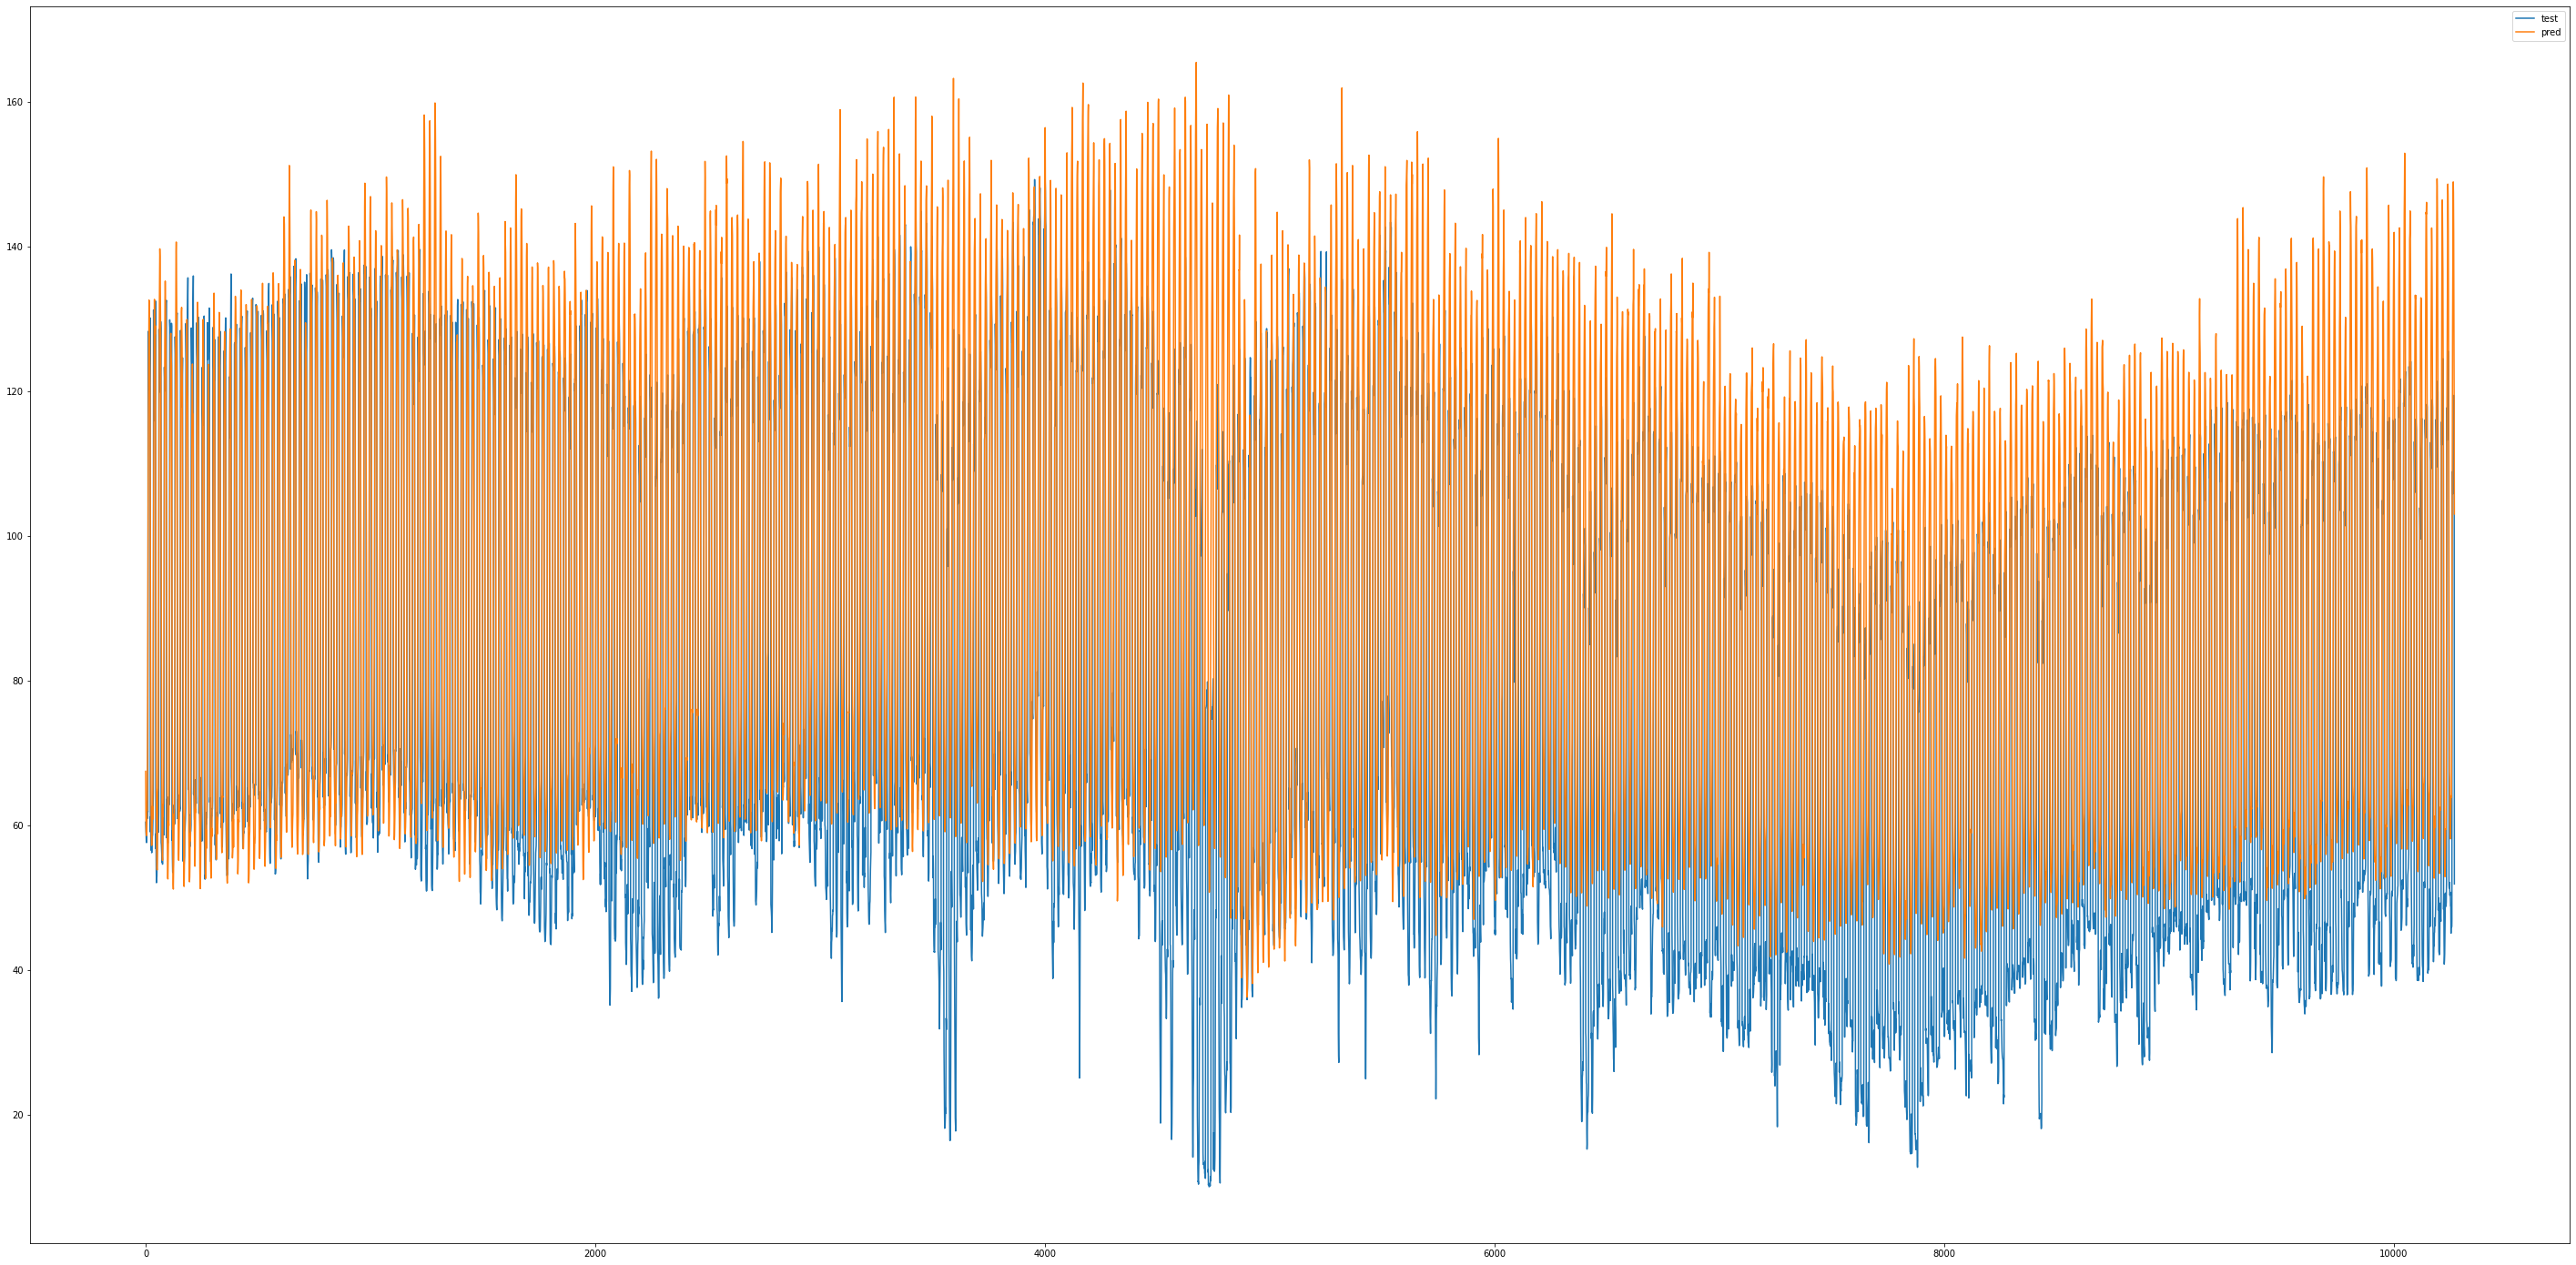

In [10]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r2 = r2_score(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse + ' and Test R2: %.3f' % r2)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

In [11]:
pd.DataFrame({'y_test':inv_y, 'y_pred':inv_yhat},index = y_test_aux.index).to_csv('./../Visualization/Neural_network_time_series_1_LSTM.csv')

# Segundo modelo

In [12]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [13]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [14]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [15]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [16]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']+model_columns]

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)

# Then we split into X and y:
X = df3.loc[:,model_columns]
y = df3.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

# We separate into train and test:
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,]

# Pasamos a float todo:
X_train = X_train_aux.values.astype('float32')
y_train = y_train_aux.values.astype('float32')
X_test = X_test_aux.values.astype('float32')
y_test = y_test_aux.values.astype('float32')

Epoch 1/60
91/91 - 1s - loss: 0.0349 - val_loss: 0.0146
Epoch 2/60
91/91 - 1s - loss: 0.0123 - val_loss: 0.0112
Epoch 3/60
91/91 - 1s - loss: 0.0113 - val_loss: 0.0097
Epoch 4/60
91/91 - 1s - loss: 0.0138 - val_loss: 0.0116
Epoch 5/60
91/91 - 1s - loss: 0.0121 - val_loss: 0.0098
Epoch 6/60
91/91 - 0s - loss: 0.0095 - val_loss: 0.0093
Epoch 7/60
91/91 - 1s - loss: 0.0087 - val_loss: 0.0126
Epoch 8/60
91/91 - 1s - loss: 0.0092 - val_loss: 0.0098
Epoch 9/60
91/91 - 1s - loss: 0.0080 - val_loss: 0.0091
Epoch 10/60
91/91 - 1s - loss: 0.0081 - val_loss: 0.0091
Epoch 11/60
91/91 - 1s - loss: 0.0079 - val_loss: 0.0092
Epoch 12/60
91/91 - 1s - loss: 0.0073 - val_loss: 0.0095
Epoch 13/60
91/91 - 1s - loss: 0.0071 - val_loss: 0.0100
Epoch 14/60
91/91 - 1s - loss: 0.0073 - val_loss: 0.0103
Epoch 15/60
91/91 - 1s - loss: 0.0075 - val_loss: 0.0108
Epoch 16/60
91/91 - 1s - loss: 0.0079 - val_loss: 0.0114
Epoch 17/60
91/91 - 1s - loss: 0.0081 - val_loss: 0.0125
Epoch 18/60
91/91 - 1s - loss: 0.0089 - 

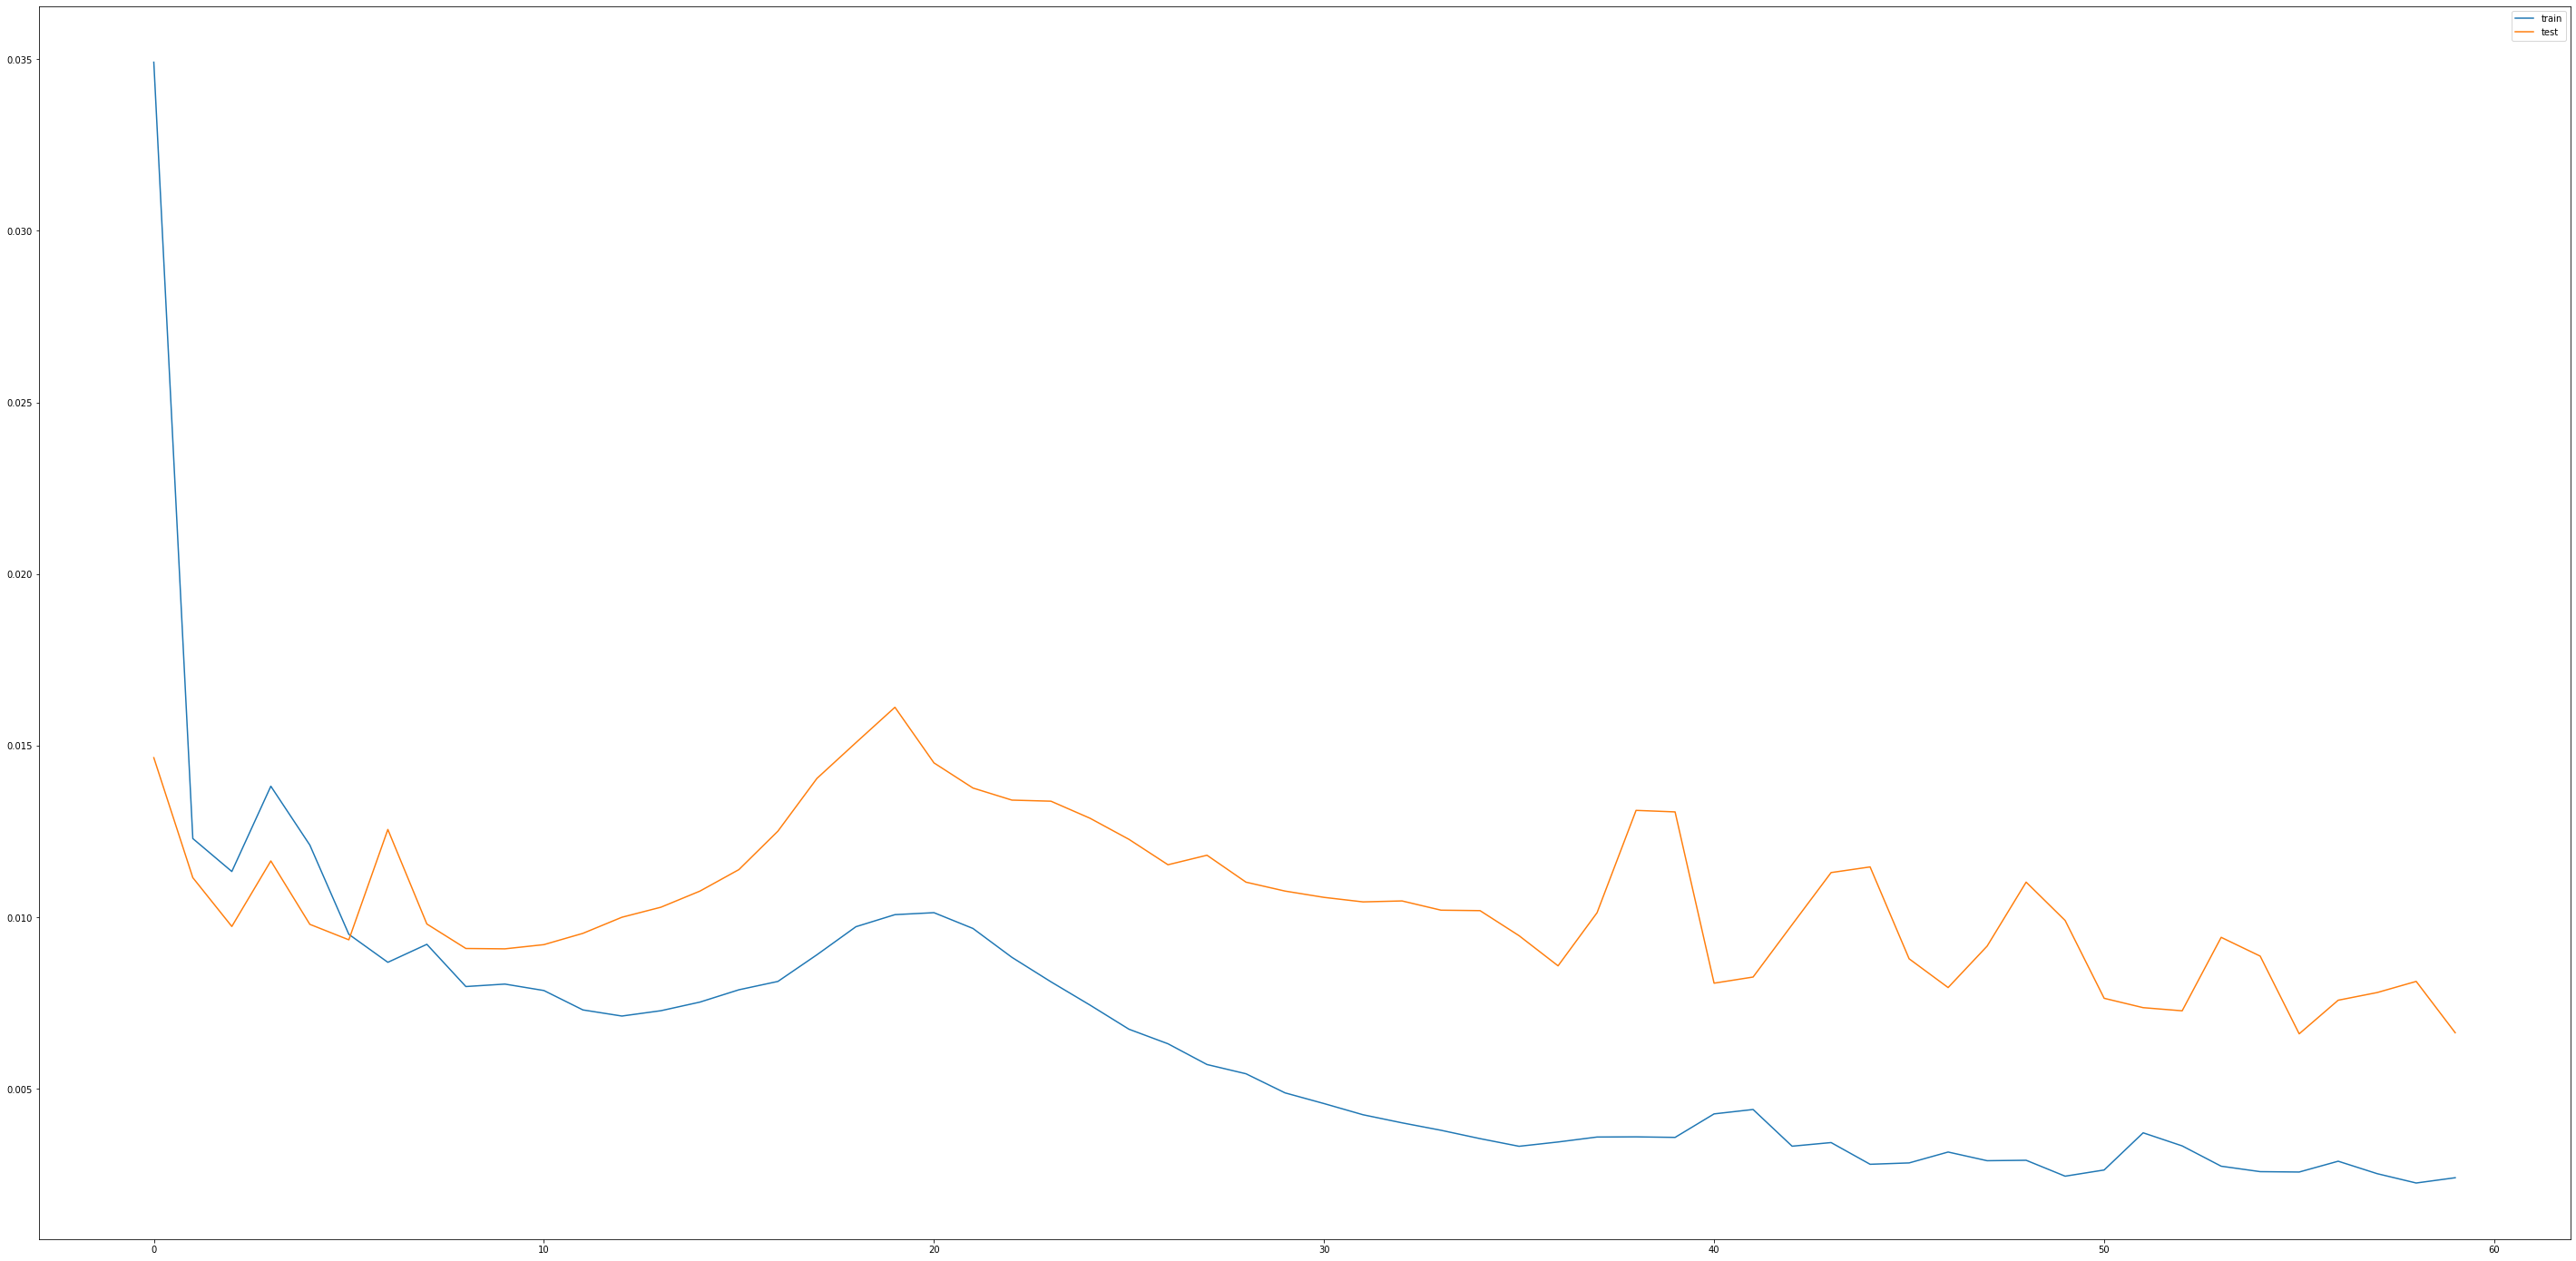

In [17]:
# design network
model = Sequential()
#model.add(Dense(2048, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=60, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 17.219 and Test R2: 0.771


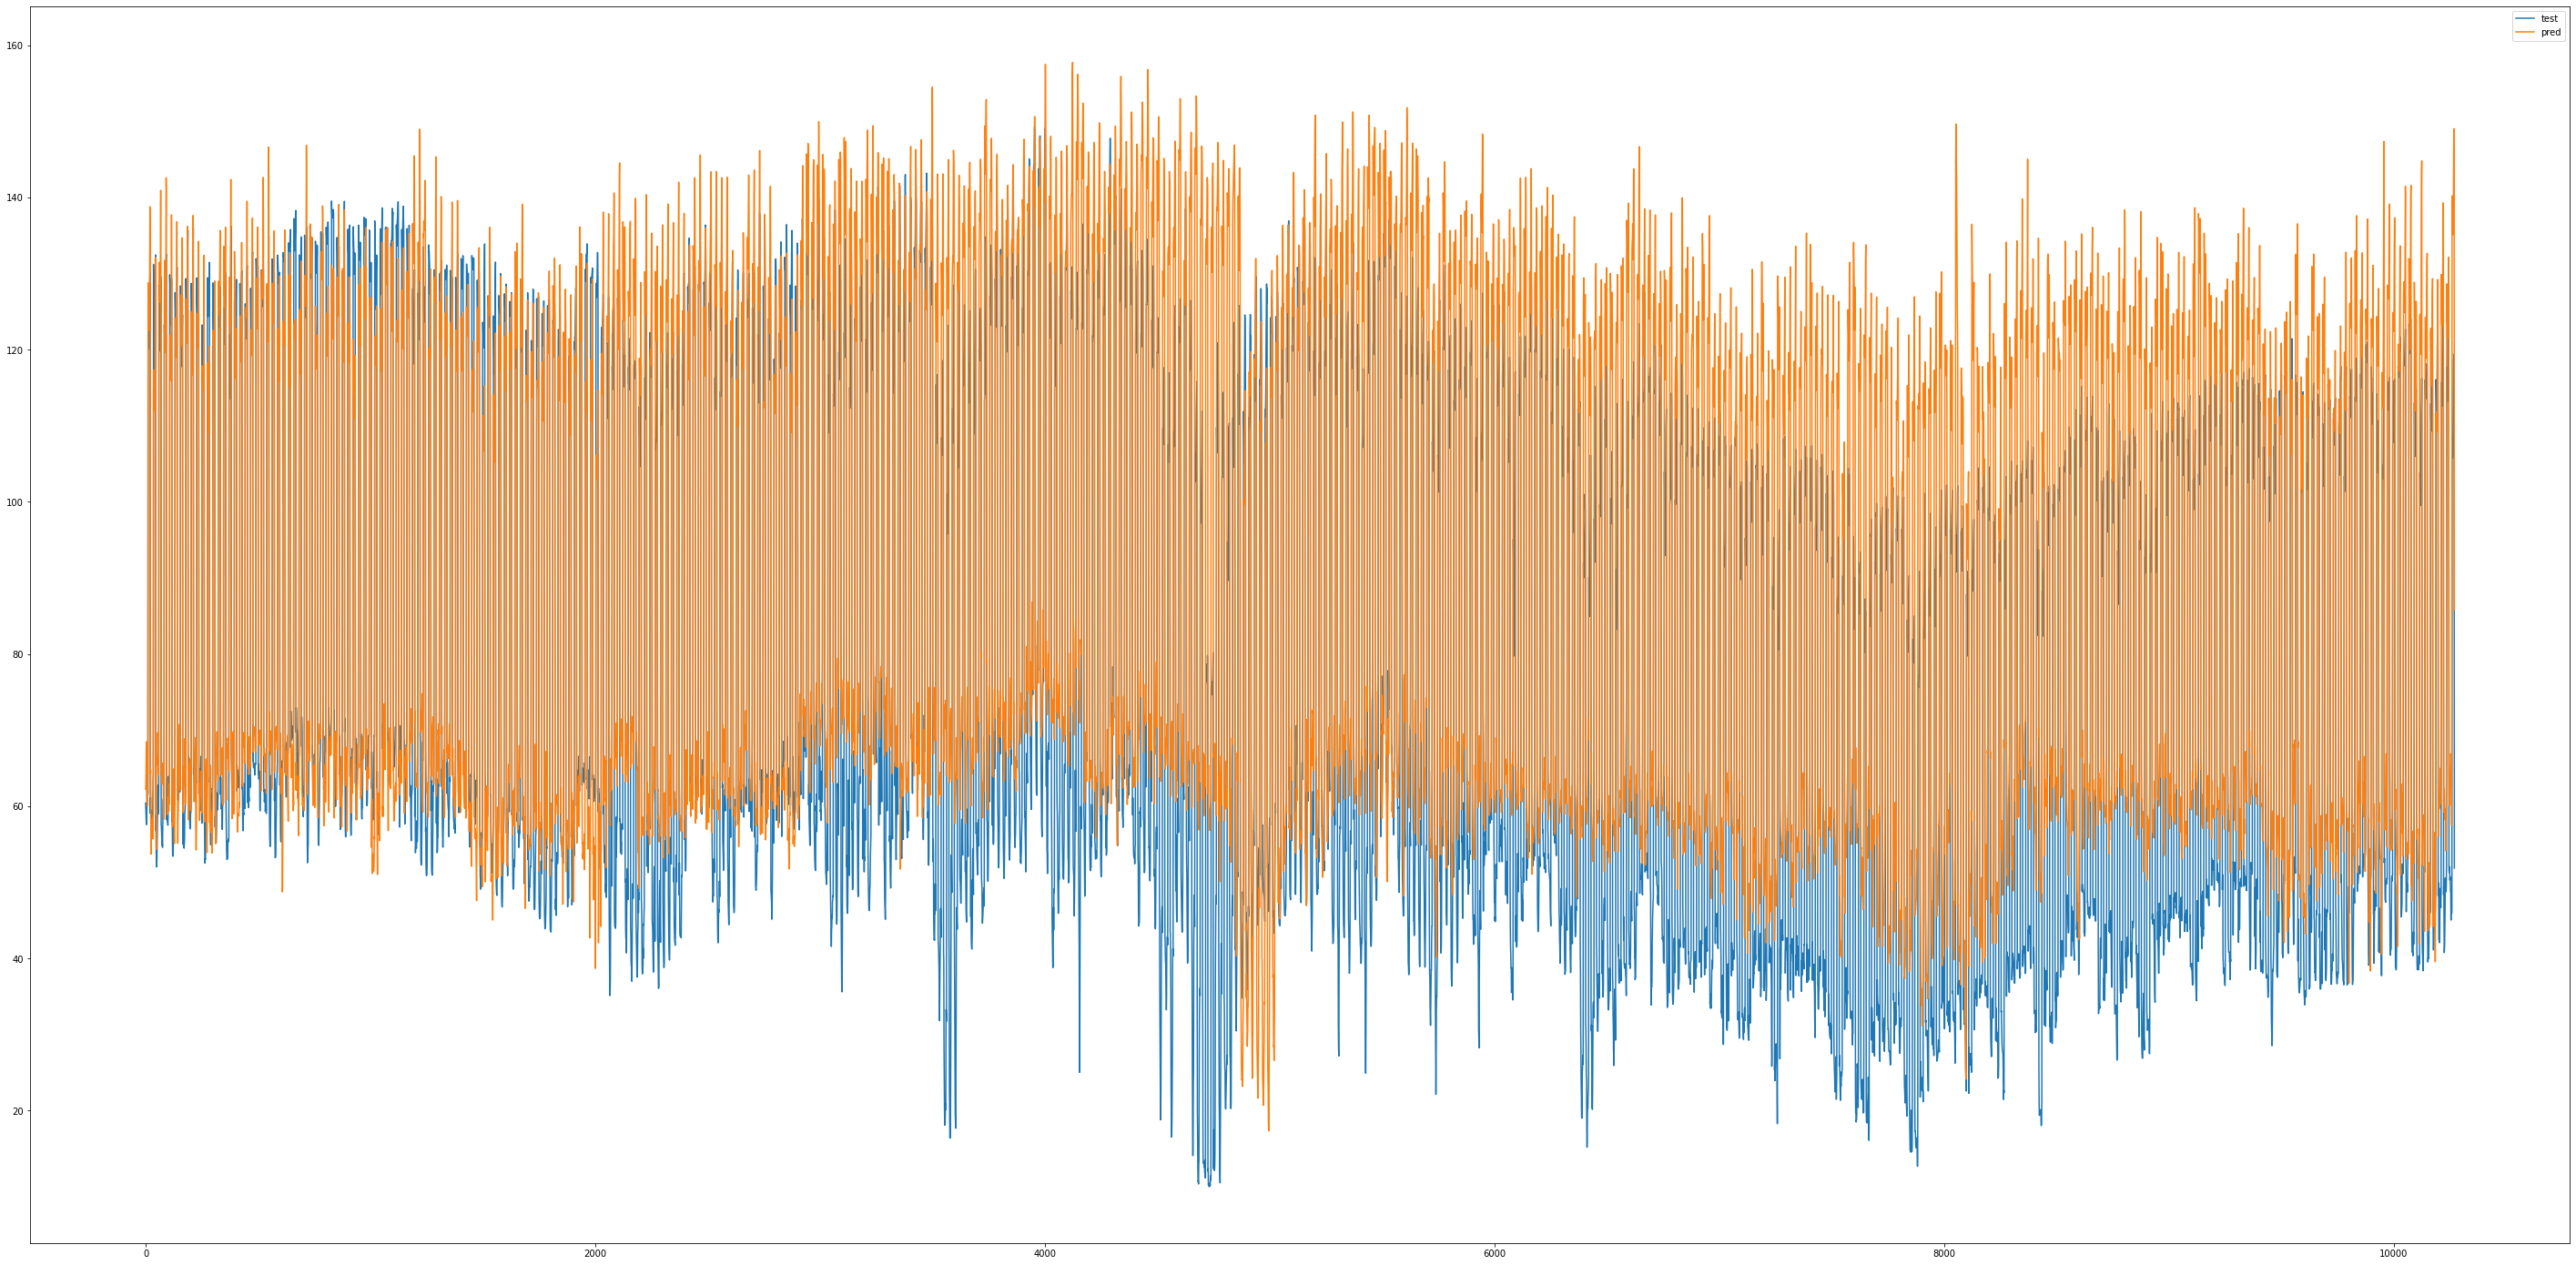

In [18]:
# make a prediction
yhat = model.predict(X_test)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = np.concatenate((y_test.reshape(-1,1), X_test[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r2 = r2_score(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse + ' and Test R2: %.3f' % r2)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

In [19]:
pd.DataFrame({'y_test':inv_y, 'y_pred':inv_yhat},index = y_test_aux.index).to_csv('./../Visualization/Neural_network_time_series_CNN.csv')

# Tercer modelo

In [20]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [21]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [22]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [23]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [24]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']+model_columns]

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)

# Then we split into X and y:
X = df3.loc[:,model_columns]
y = df3.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

# We separate into train and test:
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,]

# Pasamos a float todo:
X_train = X_train_aux.values.astype('float32')
y_train = y_train_aux.values.astype('float32')
X_test = X_test_aux.values.astype('float32')
y_test = y_test_aux.values.astype('float32')

In [25]:
# Comprobamos el porcentaje de divivsión entre train y test
y_test.shape[0]/(y_train.shape[0]+y_test.shape[0])

0.18488514437963563

In [26]:
# Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Epoch 1/80
16/16 - 2s - loss: 0.1295 - val_loss: 0.0280
Epoch 2/80
16/16 - 1s - loss: 0.0446 - val_loss: 0.0258
Epoch 3/80
16/16 - 1s - loss: 0.0370 - val_loss: 0.0343
Epoch 4/80
16/16 - 1s - loss: 0.0291 - val_loss: 0.0249
Epoch 5/80
16/16 - 1s - loss: 0.0261 - val_loss: 0.0254
Epoch 6/80
16/16 - 1s - loss: 0.0221 - val_loss: 0.0199
Epoch 7/80
16/16 - 1s - loss: 0.0179 - val_loss: 0.0148
Epoch 8/80
16/16 - 1s - loss: 0.0149 - val_loss: 0.0110
Epoch 9/80
16/16 - 1s - loss: 0.0129 - val_loss: 0.0101
Epoch 10/80
16/16 - 1s - loss: 0.0119 - val_loss: 0.0099
Epoch 11/80
16/16 - 1s - loss: 0.0116 - val_loss: 0.0095
Epoch 12/80
16/16 - 1s - loss: 0.0113 - val_loss: 0.0084
Epoch 13/80
16/16 - 1s - loss: 0.0115 - val_loss: 0.0079
Epoch 14/80
16/16 - 1s - loss: 0.0135 - val_loss: 0.0084
Epoch 15/80
16/16 - 1s - loss: 0.0221 - val_loss: 0.0316
Epoch 16/80
16/16 - 1s - loss: 0.0321 - val_loss: 0.0143
Epoch 17/80
16/16 - 1s - loss: 0.0177 - val_loss: 0.0110
Epoch 18/80
16/16 - 1s - loss: 0.0130 - 

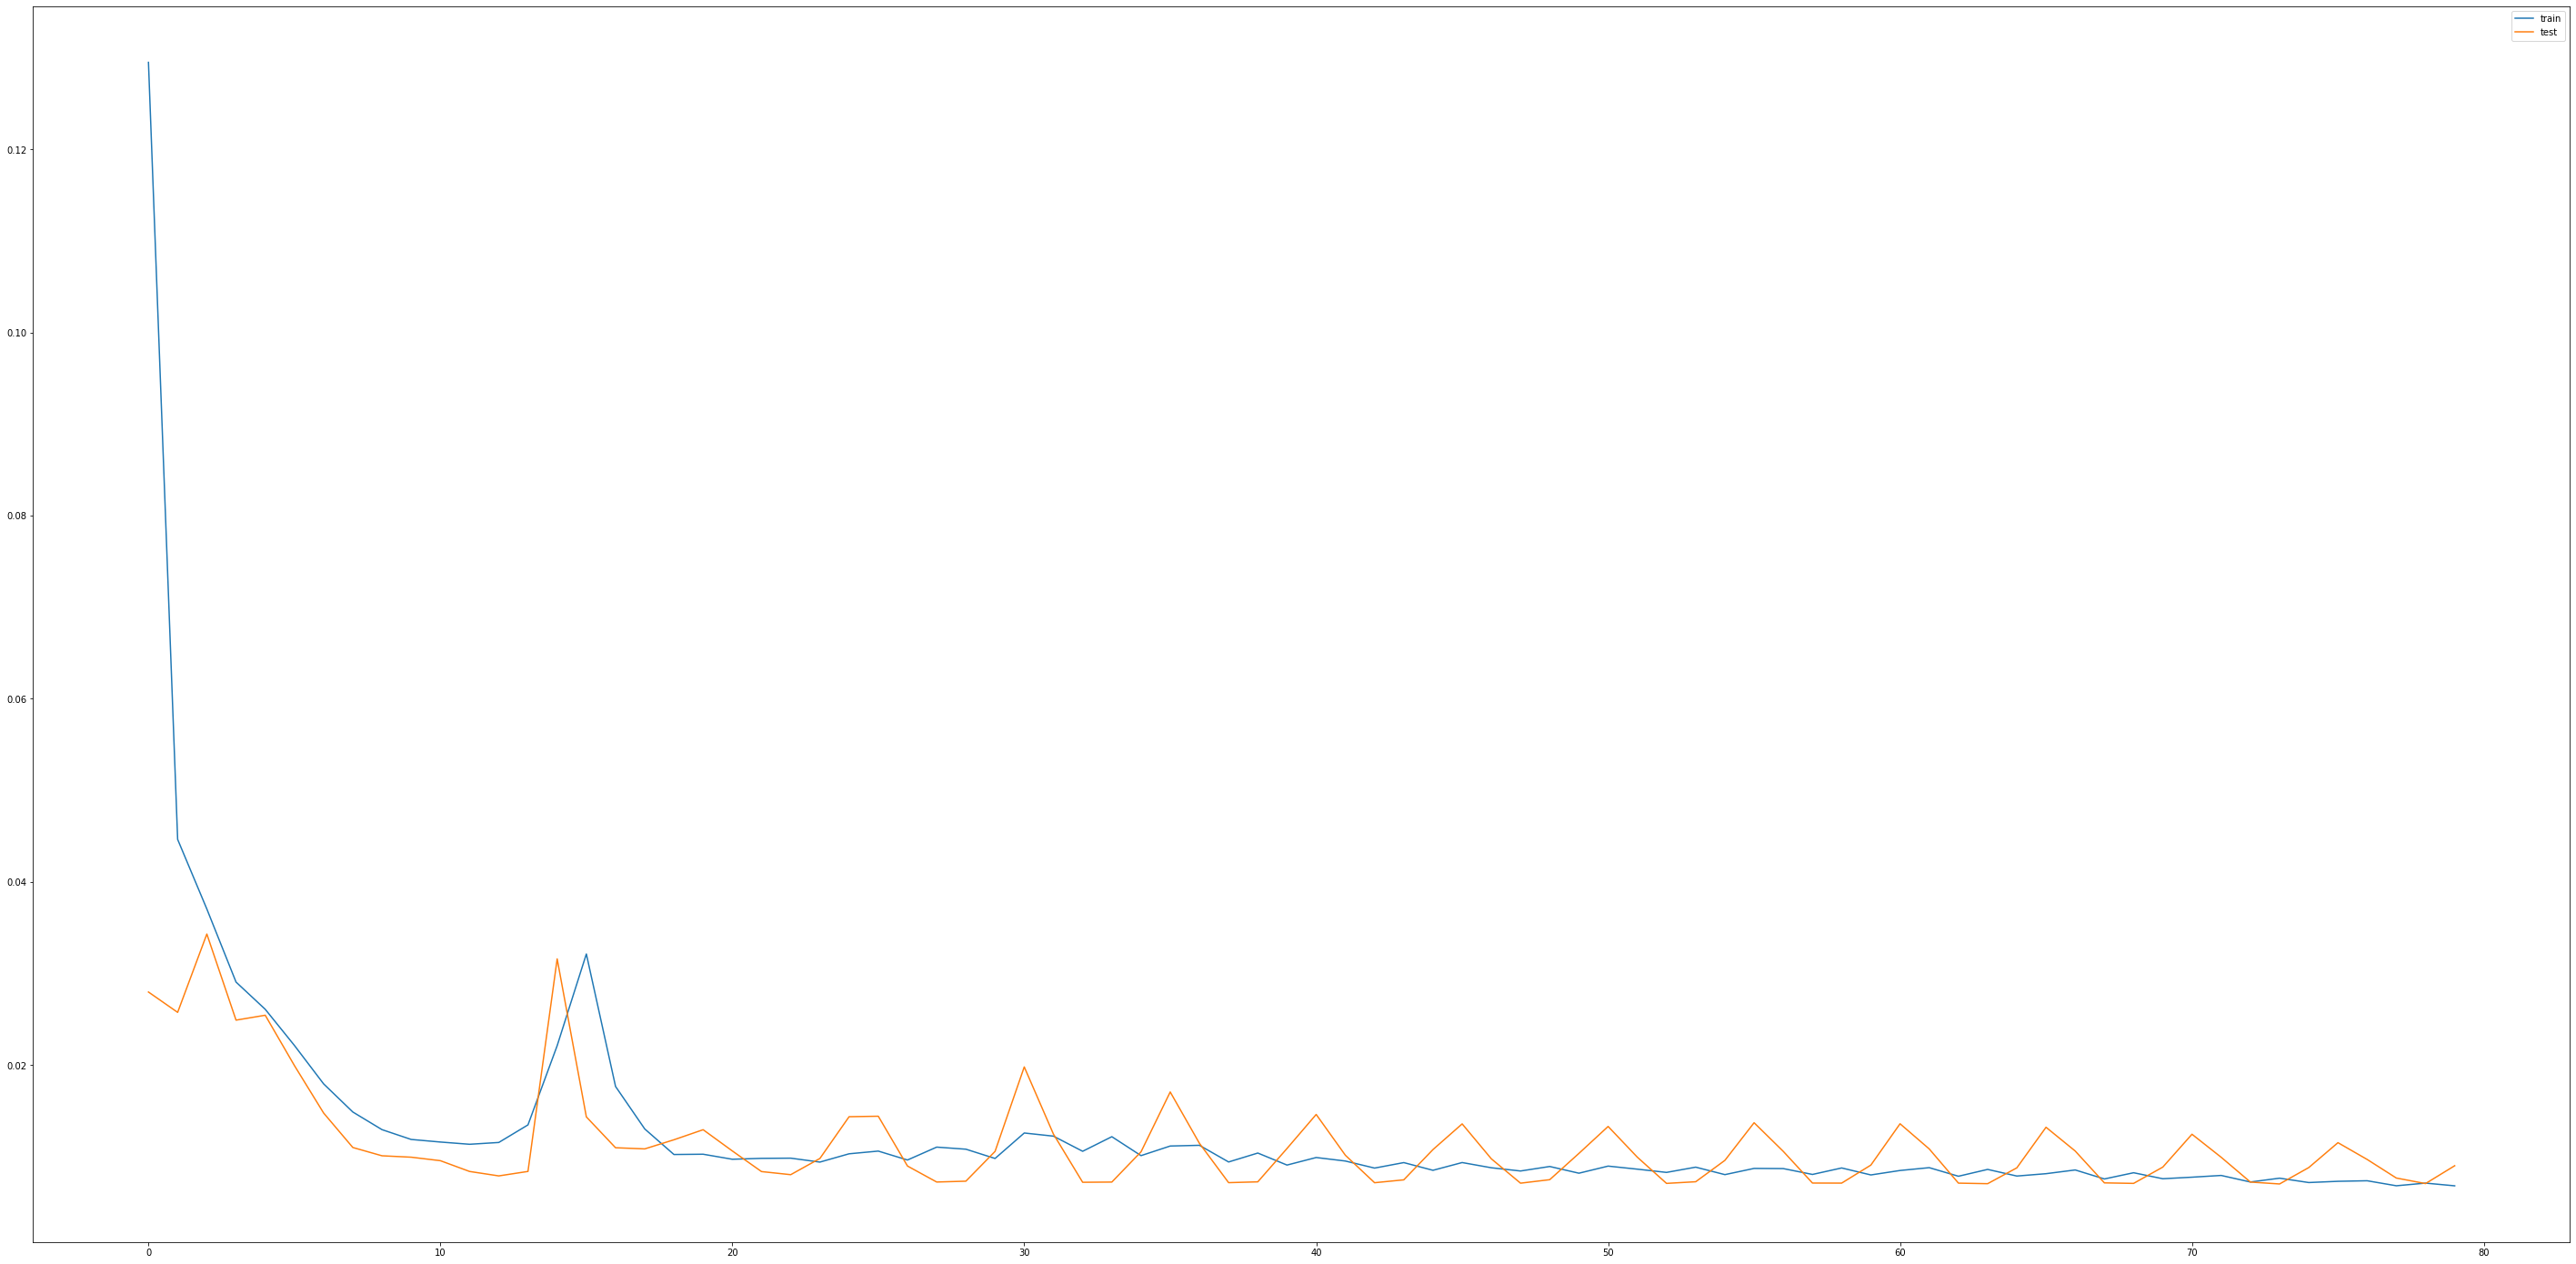

CPU times: user 5min 53s, sys: 23.7 s, total: 6min 16s
Wall time: 1min 17s


In [27]:
%%time
# design network
regressor2 = Sequential()

regressor2.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor2.add(Dropout(0.25))

regressor2.add(LSTM(units = 100, return_sequences = True))
regressor2.add(Dropout(0.1))

regressor2.add(LSTM(units = 50))
regressor2.add(Dropout(0.1))

regressor2.add(Dense(units = 1))

regressor2.compile(optimizer = 'adam', loss = 'mse')

history = regressor2.fit(X_train, y_train, epochs = 80, batch_size = 3000, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 20.053


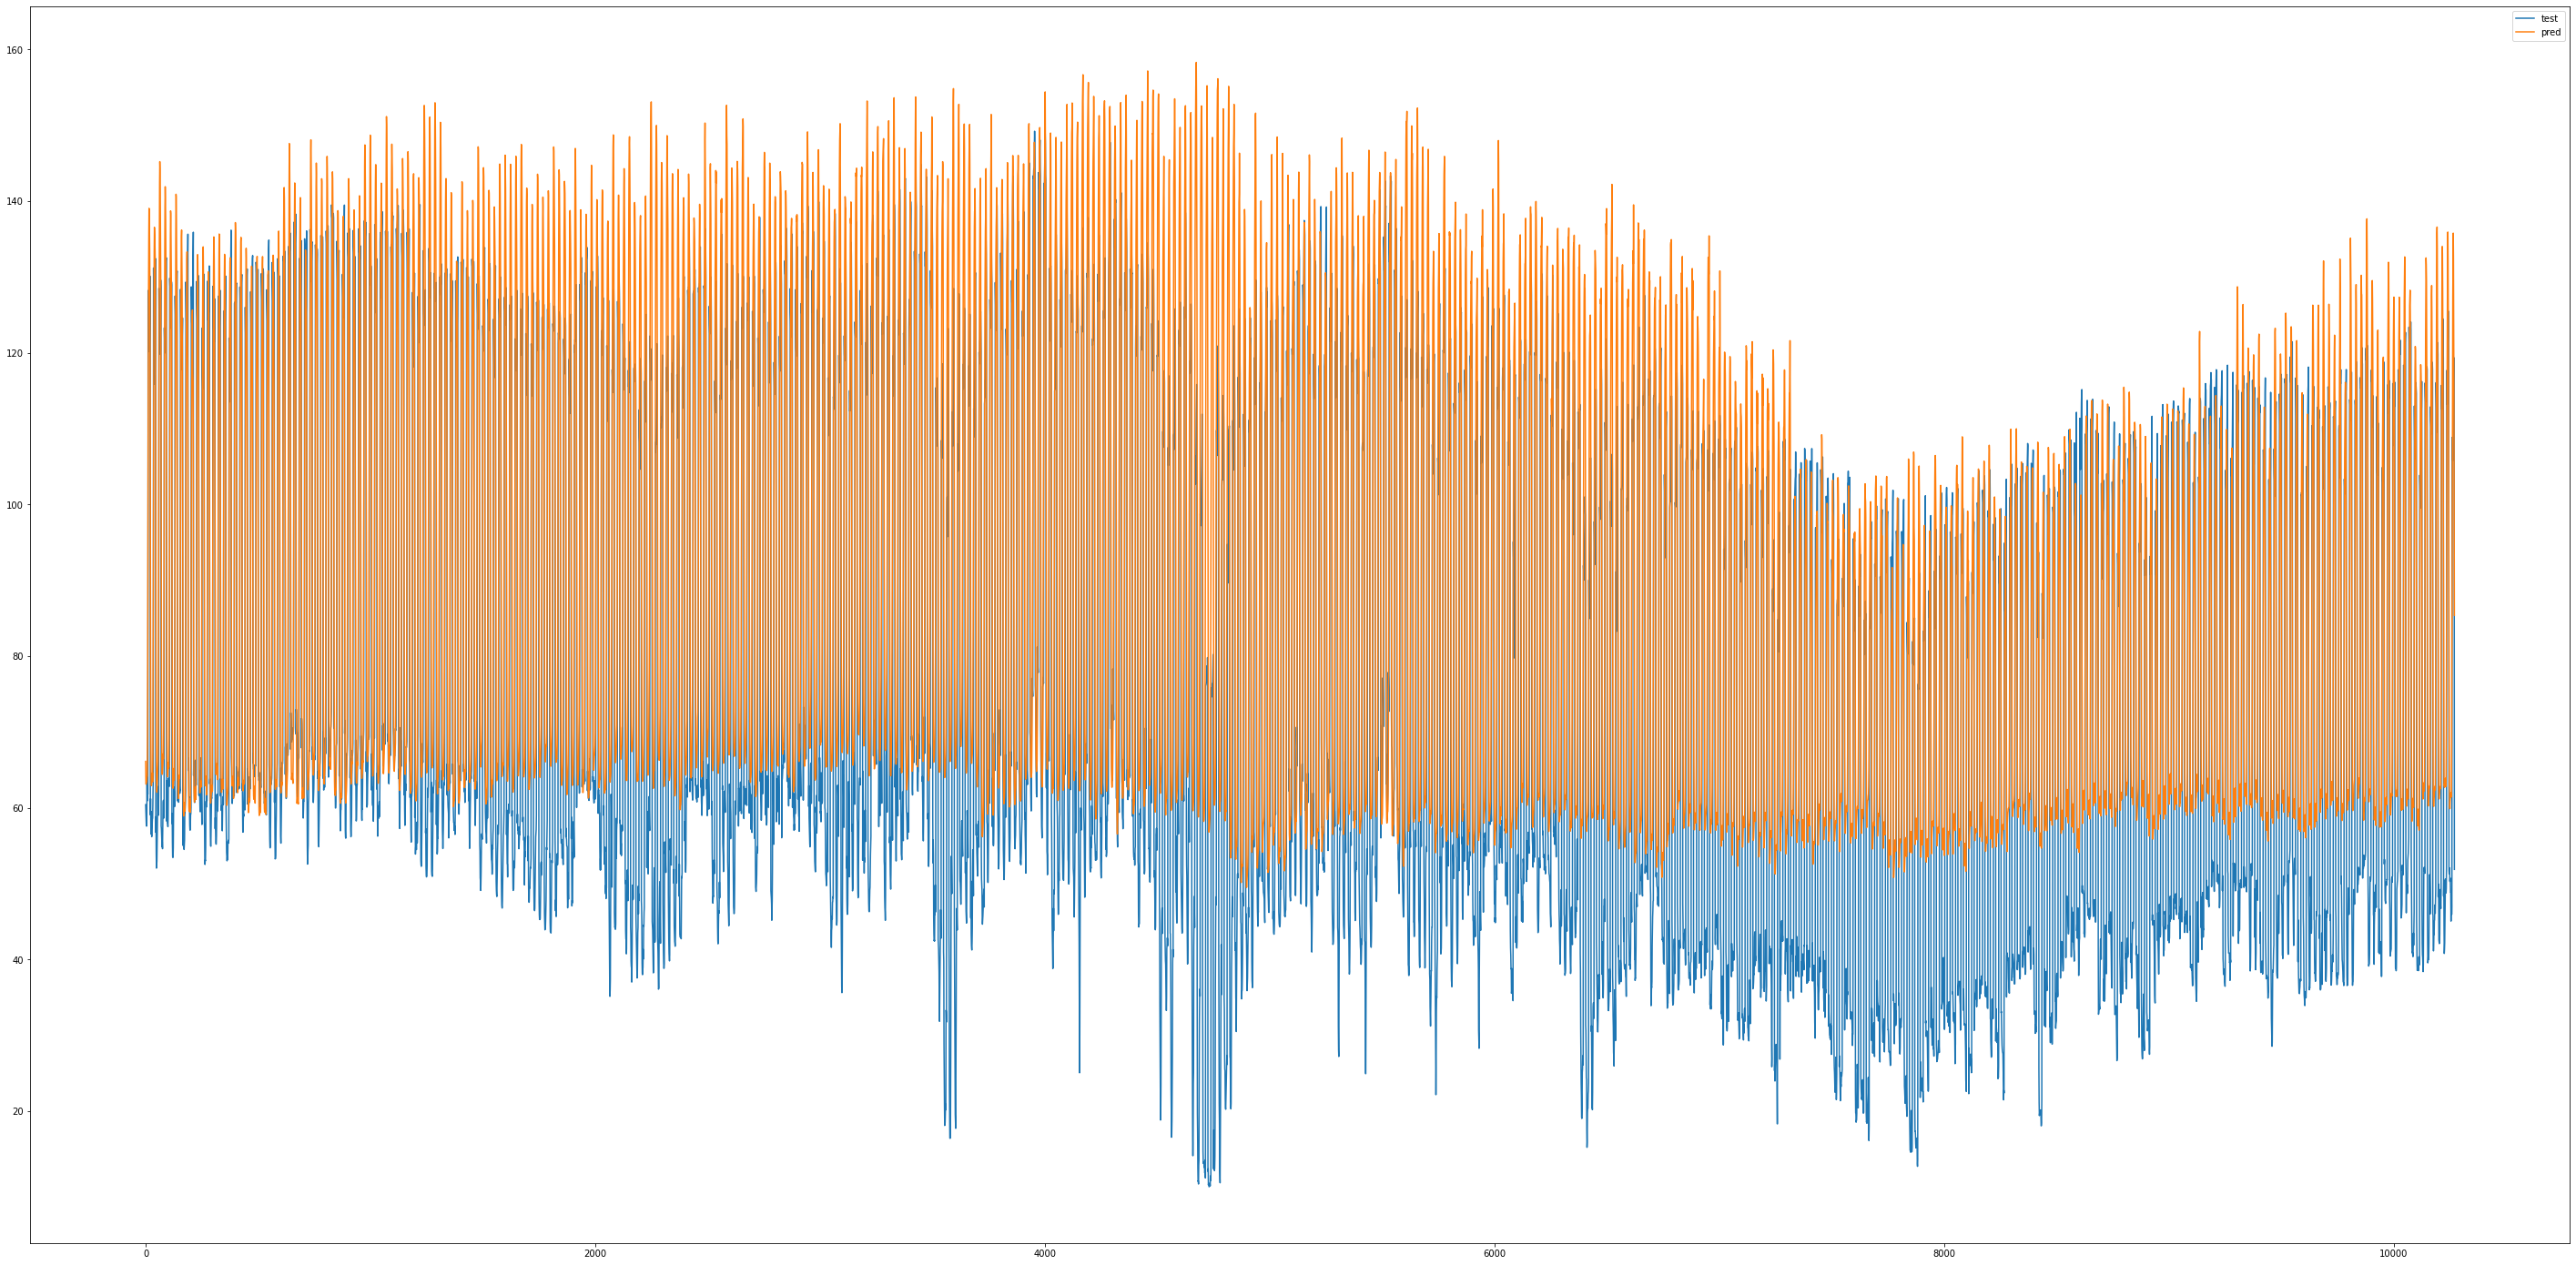

In [28]:
# make a prediction
yhat = regressor2.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

In [29]:
pd.DataFrame({'y_test':inv_y, 'y_pred':inv_yhat},index = y_test_aux.index).to_csv('./../Visualization/Neural_network_time_series_multiple_LSTM.csv')

# Si nos centramos en dividir los datos no como una serie temporal sino como un regresor:

In [30]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [31]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [32]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [33]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [34]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']+model_columns]

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)

# Then we split into X and y:
X = df3.loc[:,model_columns]
y = df3.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

X_train_aux2, X_test_aux, y_train_aux2, y_test_aux = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)
X_train_aux, X_validation_aux, y_train_aux, y_validation_aux = train_test_split(X_train_aux2, y_train_aux2, train_size=0.8,test_size=0.2, random_state=101)


# Pasamos a float todo:
X_train = X_train_aux.values.astype('float32')
y_train = y_train_aux.values.astype('float32')
X_test = X_test_aux.values.astype('float32')
y_test = y_test_aux.values.astype('float32')
X_validation = X_validation_aux.values.astype('float32')
y_validation = y_validation_aux.values.astype('float32')

Epoch 1/100
36/36 - 5s - loss: 0.0273 - val_loss: 0.0093
Epoch 2/100
36/36 - 5s - loss: 0.0069 - val_loss: 0.0058
Epoch 3/100
36/36 - 5s - loss: 0.0049 - val_loss: 0.0046
Epoch 4/100
36/36 - 5s - loss: 0.0035 - val_loss: 0.0034
Epoch 5/100
36/36 - 5s - loss: 0.0022 - val_loss: 0.0018
Epoch 6/100
36/36 - 5s - loss: 0.0017 - val_loss: 0.0016
Epoch 7/100
36/36 - 5s - loss: 0.0023 - val_loss: 0.0019
Epoch 8/100
36/36 - 5s - loss: 0.0016 - val_loss: 0.0015
Epoch 9/100
36/36 - 5s - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
36/36 - 5s - loss: 0.0011 - val_loss: 0.0012
Epoch 11/100
36/36 - 5s - loss: 0.0010 - val_loss: 0.0012
Epoch 12/100
36/36 - 5s - loss: 9.3228e-04 - val_loss: 0.0010
Epoch 13/100
36/36 - 5s - loss: 0.0010 - val_loss: 0.0011
Epoch 14/100
36/36 - 5s - loss: 0.0011 - val_loss: 9.6576e-04
Epoch 15/100
36/36 - 5s - loss: 8.1874e-04 - val_loss: 7.9544e-04
Epoch 16/100
36/36 - 5s - loss: 6.7154e-04 - val_loss: 7.7306e-04
Epoch 17/100
36/36 - 5s - loss: 6.1632e-04 - val_loss: 9.

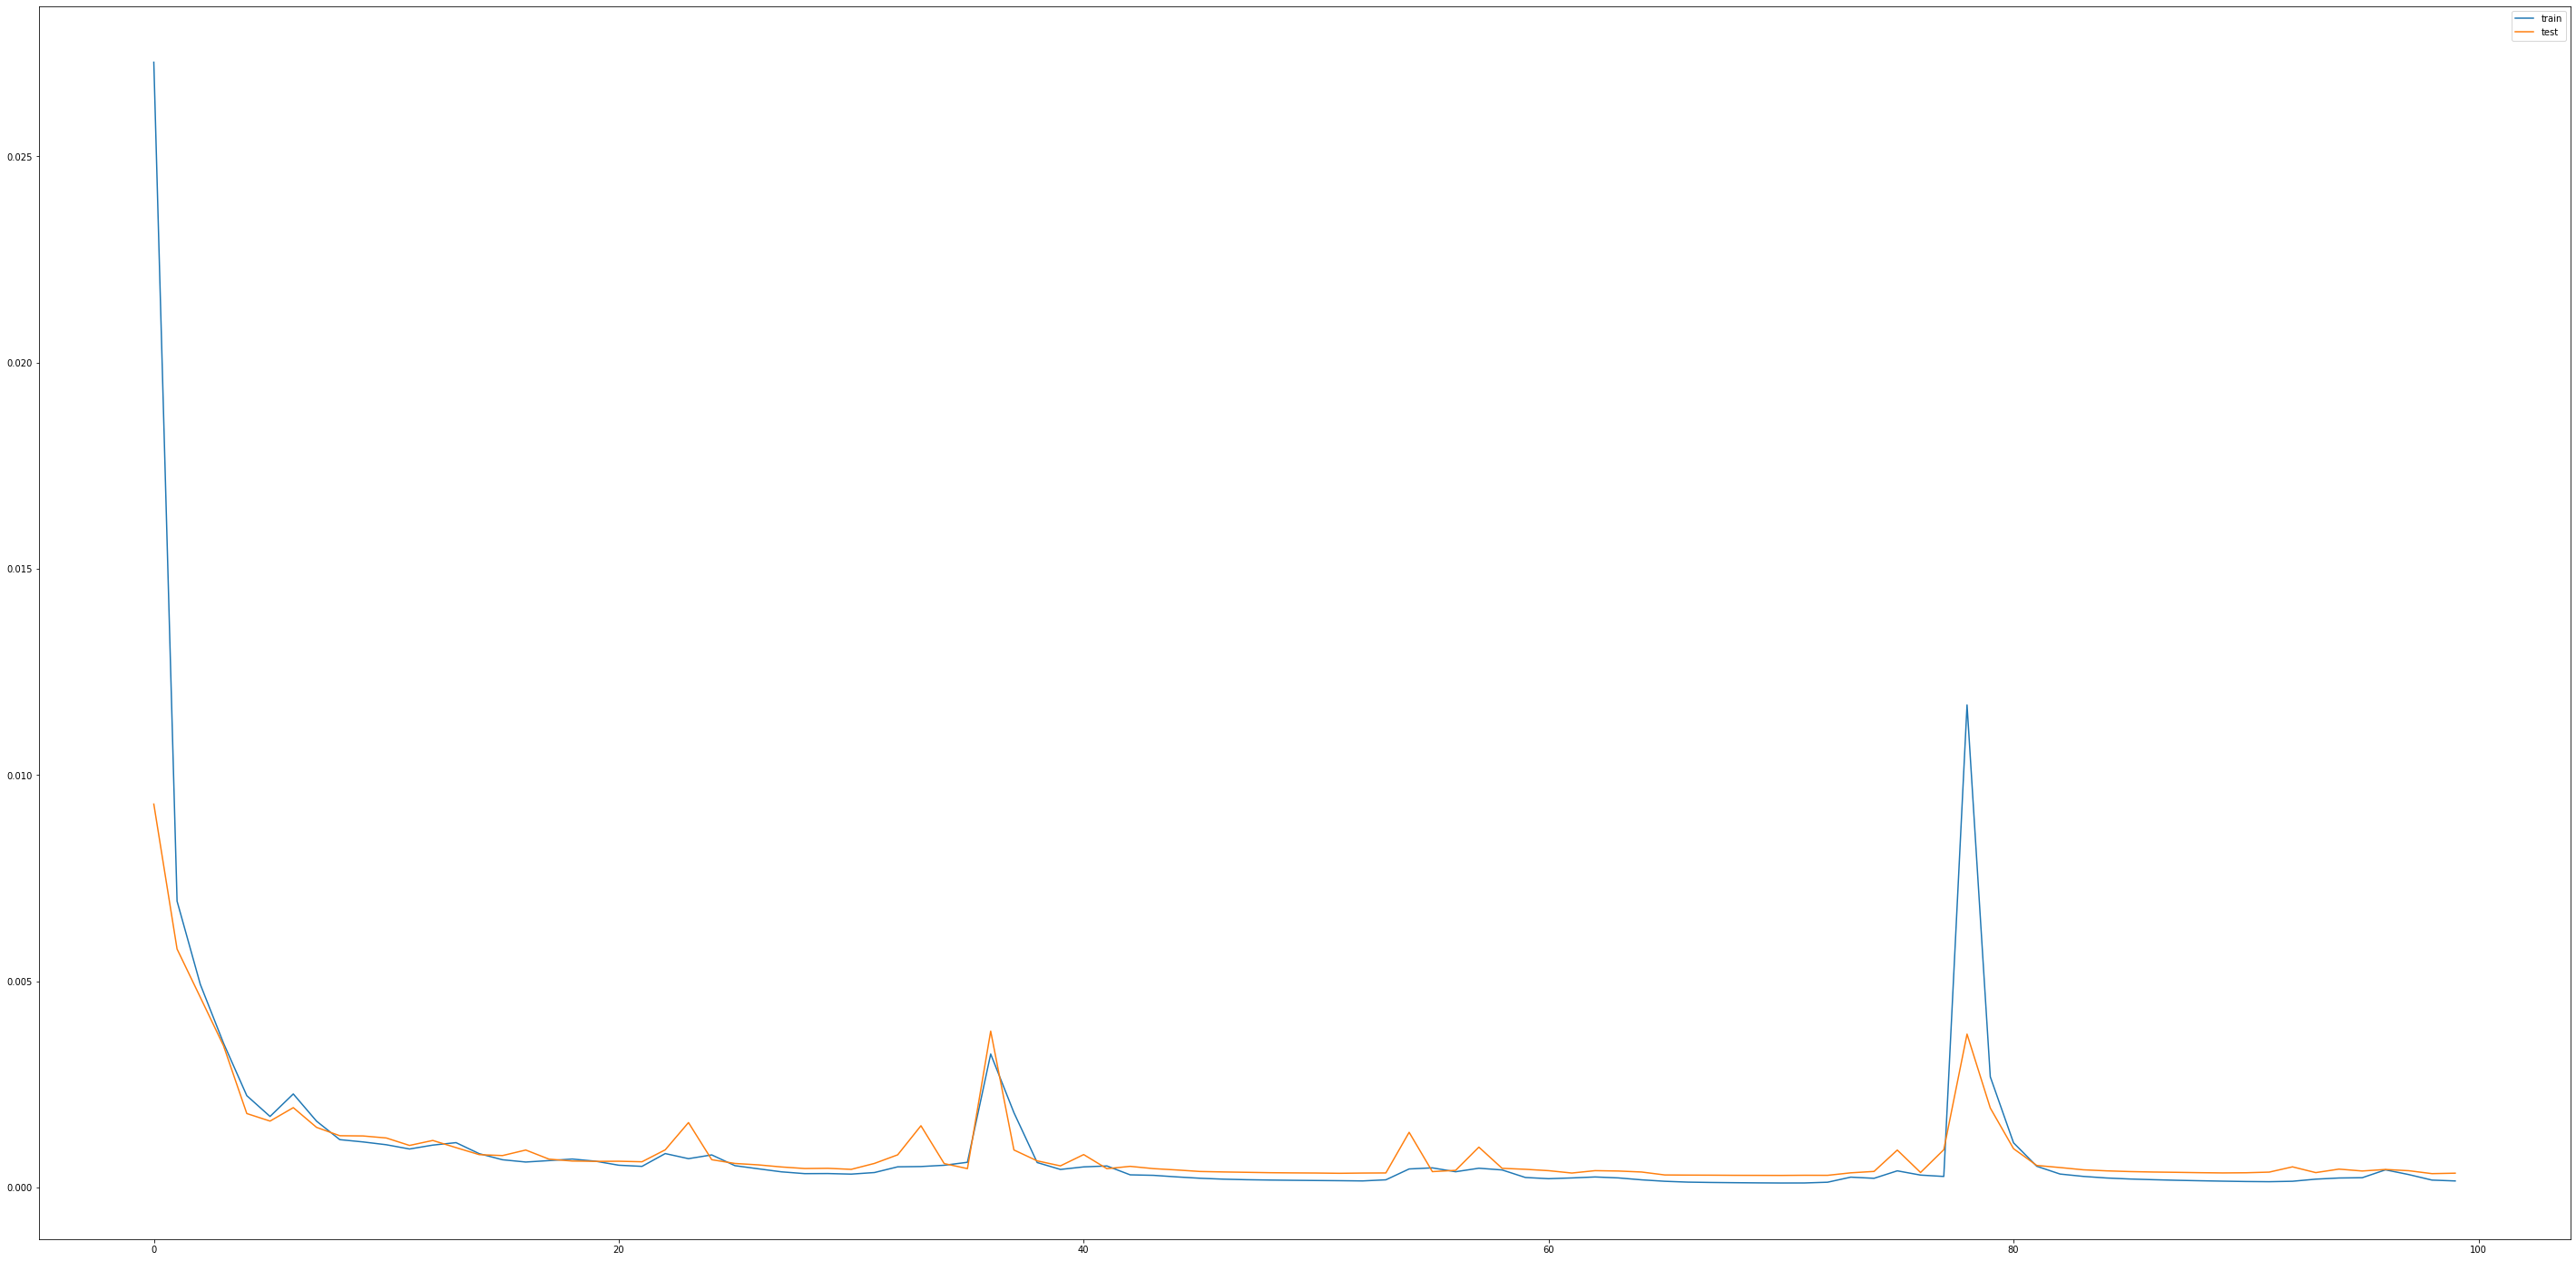

In [35]:
# design network
model = Sequential()
model.add(Dense(2048, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=1000, validation_data=(X_validation_aux, y_validation_aux), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 3.802 and Test R2: 0.990


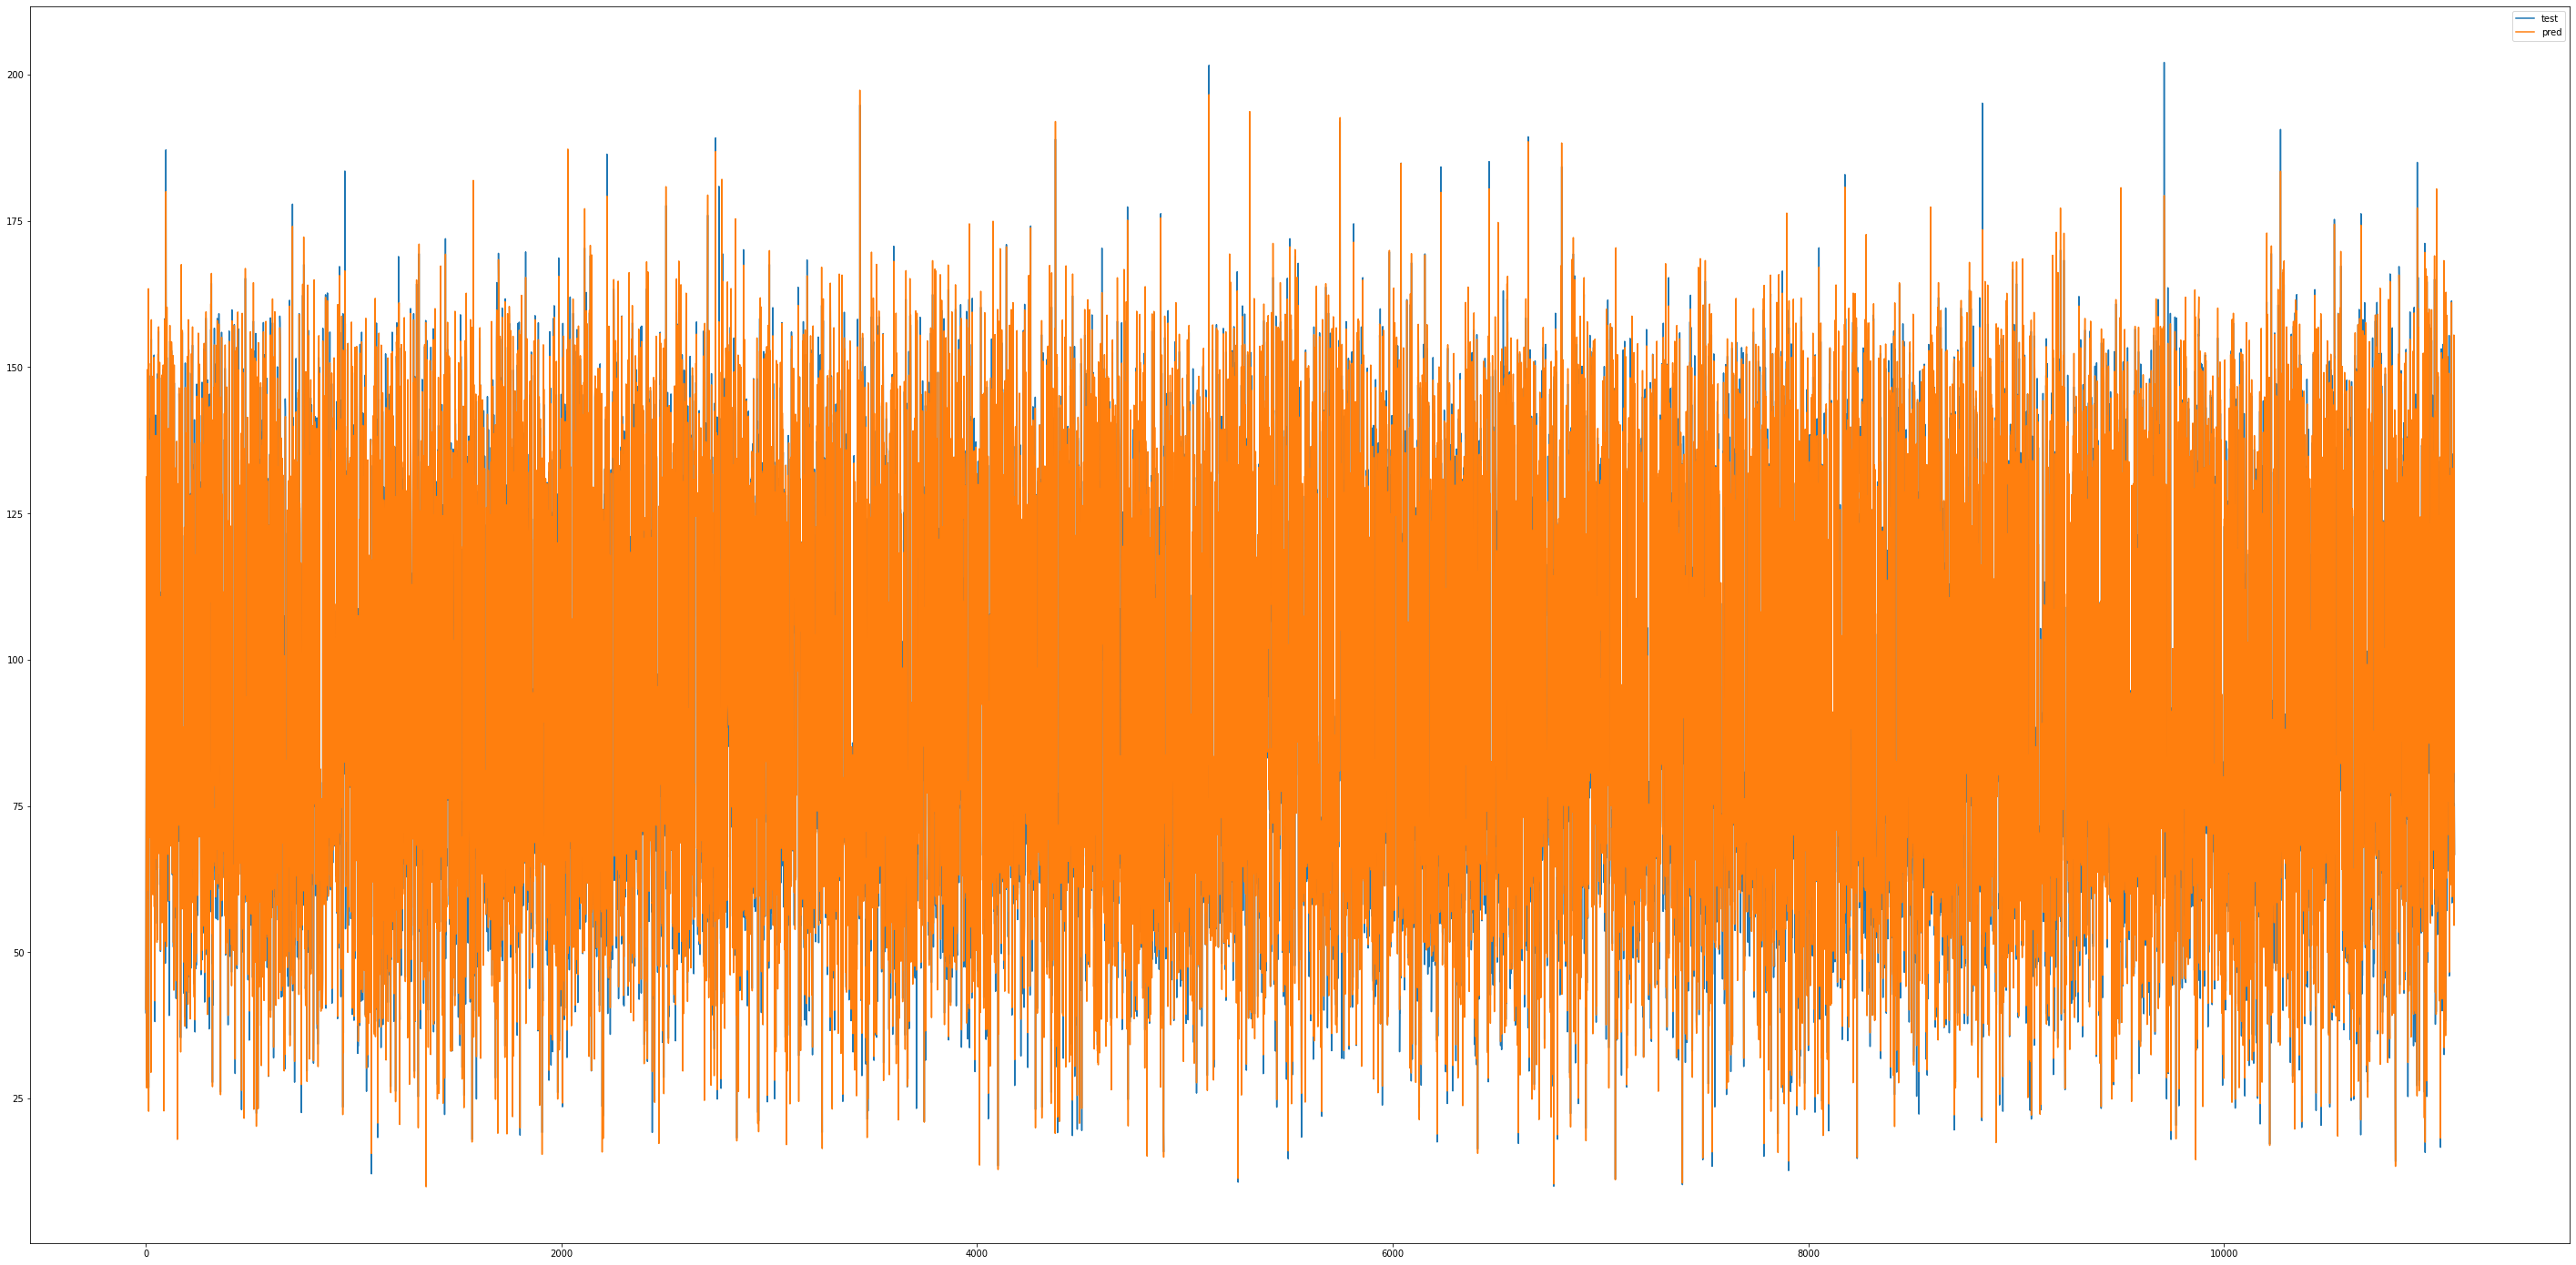

In [36]:
# make a prediction
yhat = model.predict(X_test)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = np.concatenate((y_test.reshape(-1,1), X_test[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r2 = r2_score(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse + ' and Test R2: %.3f' % r2)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

In [37]:
pd.DataFrame({'y_test':inv_y, 'y_pred':inv_yhat},index = y_test_aux.index).to_csv('./../Visualization/Neural_network_CNN.csv')